In [1]:
import pyNN.nest as p
from pyNN.random import NumpyRNG, RandomDistribution
from pyNN.utility import Timer
import pylab
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

timer = Timer()
ts = 0.1
simulation_time = 20

#p.setup(timestep=ts, min_delay=ts, max_delay=2.0*ts) # 0.1ms 
p.setup(timestep=ts) # 0.1ms



0

In [2]:
def compute_network_state(n_res, w_exc_b, w_inh_b, rout_w_exc, rout_w_inh, inp_rate):
    n_input_neurons     = 10
    n_readout_neurons   = 2
    n_reservoir_neurons = n_res
    exc_rate            = 0.8 # % of excitatory neurons in reservoir

    n_exc = int(round(n_reservoir_neurons*exc_rate))
    n_inh = n_reservoir_neurons-n_exc
    izh_celltype = p.native_cell_type('izhikevich')
    if_celltype = p.IF_curr_exp
    celltype = izh_celltype
    
    spike_source = p.native_cell_type('poisson_generator')
    inp_pop=p.Population(n_input_neurons,spike_source,{'rate':inp_rate})
    
    exc_cells = p.Population(n_exc, celltype, label="Excitatory_Cells")
    inh_cells = p.Population(n_inh, celltype, label="Inhibitory_Cells")

    # initialize with a uniform random distributin
    # use seeding for reproducability
    rngseed = 98766987
    parallel_safe = True
    rng = NumpyRNG(seed=rngseed, parallel_safe=parallel_safe)

    unifDistr = RandomDistribution('uniform', (-70,-65), rng=rng)
    inh_cells.initialize('V_m',unifDistr)
    exc_cells.initialize('V_m',unifDistr)
    
    readout_neurons = p.Population(2, celltype, label="readout_neuron")
    
    inp_weight=3.
    inp_delay =1

    inp_weight_distr = RandomDistribution('normal', [inp_weight, 1e-3], rng=rng)

    # connect each input neuron to 30% of the reservoir neurons
    inp_conn = p.FixedProbabilityConnector(p_connect=0.3,weights =inp_weight_distr, delays=inp_delay)

    connections = {}
    connections['inp2e'] = p.Projection(inp_pop, exc_cells, inp_conn)
    connections['inp2i'] = p.Projection(inp_pop, inh_cells, inp_conn)

    pconn = 0.01      # sparse connection probability

    # scale the weights w.r.t. the network to keep it stable
    w_exc = w_exc_b/np.sqrt(n_exc)      # nA
    w_inh = w_inh_b/np.sqrt(n_inh)   # nA
    delay_exc = 1      # defines how long (ms) the synapse takes for transmission
    delay_inh = 1

    weight_distr_exc = RandomDistribution('normal', [w_exc, 1e-3/n_exc], rng=rng)
    weight_distr_inh = RandomDistribution('normal', [w_inh, 1e-3/n_inh], rng=rng)
    exc_conn = p.FixedProbabilityConnector(pconn, weights=weight_distr_exc, delays=delay_exc)
    inh_conn = p.FixedProbabilityConnector(pconn, weights=weight_distr_inh, delays=delay_inh)

    # TODO rng=rng; receptor_type = ...
    connections['e2e'] = p.Projection(exc_cells, exc_cells, exc_conn, target='excitatory')
    connections['e2i'] = p.Projection(exc_cells, inh_cells, exc_conn, target='excitatory')
    connections['i2e'] = p.Projection(inh_cells, exc_cells, inh_conn, target='inhibitory')
    connections['i2i'] = p.Projection(inh_cells, inh_cells, inh_conn, target='inhibitory')
    
    #rout_w_exc = 20   # nA
    #rout_w_inh = -80   # nA
    # 20, -51

    rout_conn_exc = p.AllToAllConnector(weights=rout_w_exc, delays=delay_exc)
    rout_conn_inh = p.AllToAllConnector(weights=rout_w_inh, delays=delay_exc)


    connections['e2rout'] = p.Projection(exc_cells, readout_neurons, rout_conn_exc, target='excitatory')
    connections['i2rout'] = p.Projection(inh_cells, readout_neurons, rout_conn_inh, target='inhibitory')
    
    readout_neurons.record()
    exc_cells.record()
    
    p.run(simulation_time)

    r_spikes = readout_neurons.getSpikes()
    exc_spikes = exc_cells.getSpikes()

    p.end()
    
    return r_spikes, exc_spikes

In [3]:
n_res=200
w_exc_b=2
w_inh_b=-8
rout_w_exc=20
rout_w_inh=-80
inp_rate=10.0

r_spikes, exc_spikes = compute_network_state(n_res, w_exc_b, w_inh_b, rout_w_exc, rout_w_inh, inp_rate)


In [4]:
def plot_spikes(spiketrain):
    st = [spike[1] for spike in spiketrain] # spike times
    sid = [spike[0] for spike in spiketrain]

    plt.plot(st, sid, "|")
    plt.axis([np.min(st), np.max(st), np.min(sid)-1, np.max(sid)+1])
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron ID')
    plt.title('Spike Plot')
    plt.xlim(xmin=0)
    plt.show()

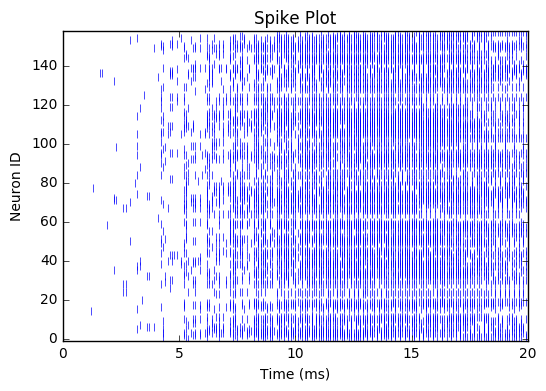

In [5]:
plot_spikes(exc_spikes)

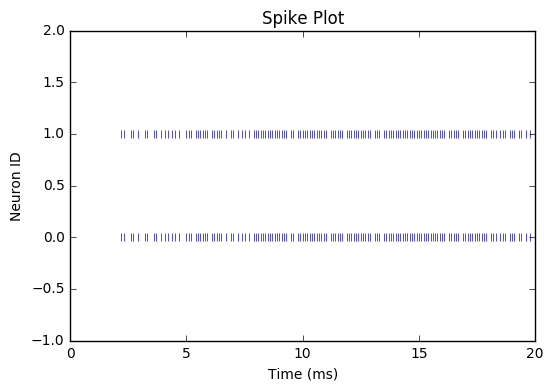

In [6]:
plot_spikes(r_spikes)

In [7]:
st = [spike[1] for spike in r_spikes]
st[:10]


[2.2000000000000002,
 2.2000000000000002,
 2.2999999999999998,
 2.2999999999999998,
 2.6000000000000001,
 2.6000000000000001,
 2.7000000000000002,
 2.7000000000000002,
 2.8999999999999999,
 2.8999999999999999]

In [8]:
r_spikes[:10]

array([[ 0. ,  2.2],
       [ 1. ,  2.2],
       [ 0. ,  2.3],
       [ 1. ,  2.3],
       [ 0. ,  2.6],
       [ 1. ,  2.6],
       [ 0. ,  2.7],
       [ 1. ,  2.7],
       [ 0. ,  2.9],
       [ 1. ,  2.9]])

In [9]:
np.shape(r_spikes)

(286, 2)

In [10]:
np.shape(exc_spikes)

(8322, 2)

In [11]:
def get_spike_rates(spikes):
    """returns the rates of all neurons in the recorded population"""
    shape=np.shape(spikes)
    spike_rates=np.zeros((int(np.max(spikes[:,0]))+1,))
    for i in range(shape[0]): # for each spikes
        for j in range(int(np.max(spikes[:,0]))+1): #for each neuron
            if spikes[i,0]==j:
                spike_rates[j]+=1
    return spike_rates

In [12]:
spike_rates=get_spike_rates(r_spikes)
spike_rates

array([ 143.,  143.])

In [13]:
res_rates=get_spike_rates(exc_spikes)
res_rates

array([   2.,   88.,   57.,  113.,   58.,   78.,   81.,    4.,   52.,
         69.,   93.,   81.,    1.,    0.,    1.,   48.,   58.,   66.,
         82.,   76.,    2.,    0.,    0.,   56.,   70.,    1.,    1.,
          0.,  100.,    5.,   81.,    0.,   73.,   88.,   94.,   50.,
          0.,   91.,   90.,   43.,   97.,    0.,   61.,   67.,   97.,
         81.,    0.,   51.,    0.,   83.,   94.,   92.,   78.,    0.,
         86.,   57.,    0.,   77.,   94.,   99.,   66.,    1.,    1.,
          0.,   88.,    0.,   71.,  109.,    1.,   76.,   76.,   68.,
        118.,   64.,   97.,   89.,   75.,    1.,   87.,   62.,    1.,
         63.,   51.,    0.,   75.,   68.,    0.,    3.,   66.,   46.,
         89.,    2.,   91.,   86.,   79.,   82.,    0.,   50.,    3.,
         89.,    7.,   77.,    1.,   76.,    0.,  111.,   97.,    1.,
         88.,   74.,   87.,   72.,   89.,   39.,  108.,   77.,   83.,
          0.,   61.,   51.,    3.,    0.,  110.,    1.,   86.,    1.,
          1.,    1.,

In [14]:
# separability: different input signals (1. rates, 2. time series of rates)
# must lead to different reservoir state vectors
# needs a distance metric

In [ ]:
n_res=200
w_exc_b=2
w_inh_b=-8
rout_w_exc=20
rout_w_inh=-80
inp_rate=20.0

r_spikes2, exc_spikes2 = compute_network_state(n_res, w_exc_b, w_inh_b, rout_w_exc, rout_w_inh, inp_rate)


In [ ]:
# todo: kernel stops when rerunning compute_network_state
